# Homework 2: Softmax

**Goal:** We learned about softmax in lecture, today, a **key** building block for learning about multi-vectored outputs (e.g, needed for constructing NNs) and for the classic NN output layer for multi-class classification.

Let's build a softmax from scratch, and train a coarse MNIST classifier rn!!

Also, for this notebook, we'll be more careful about the train / val / test split that we learned about yesterday 😁

In [1]:
# !pip install torch # we'll want to build some of the nb in torch today

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

**Download the data set:**

I downloaded the file from here: https://drive.google.com/file/d/1eEKzfmEu6WKdRlohBQiqi3PhW_uIVJVP/view

and moved it to our data directory.

In [3]:
mnist_train = np.genfromtxt('../data/MNIST_CSV/mnist_train.csv', delimiter=',')

In [4]:
y_all, X_all = mnist_train[:,0],mnist_train[:,1:]

In [5]:
X_all.shape

(60000, 784)

In [6]:
nPix = int(np.sqrt(X_all.shape[1]))
nPix

28

Text(0.5, 1.0, 'y=5.0')

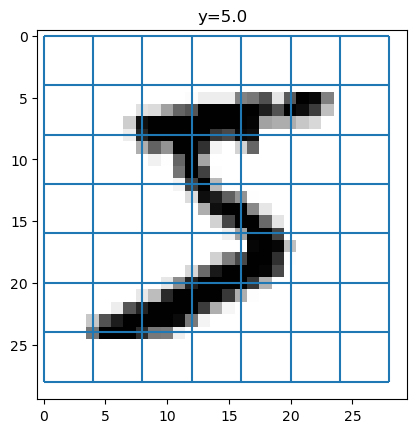

In [8]:
idx = 0

plt.imshow(X_all[idx].reshape(nPix,nPix),cmap='gray_r')

plt.hlines(np.arange(0,nPix+1,4),0,nPix)
plt.vlines(np.arange(0,nPix+1,4),0,nPix)

plt.title(f'y={y_all[idx]}')

Great! For the small MLPs we've training today, 728 is going to be a lot of features:

**Task 1:** Downsample the image to be 7x7

In [9]:
e = np.arange(0,nPix+1,4)

X_lowdim = np.vstack([X_all[idx].reshape(nPix,nPix)[i:j,:].sum(axis=0) for i,j in zip(e[:-1],e[1:])])

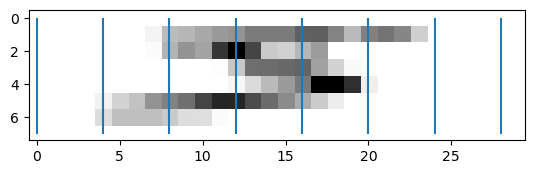

In [10]:
plt.imshow(X_lowdim,cmap='gray_r')

plt.vlines(np.arange(0,nPix+1,4),0,nPix//4)

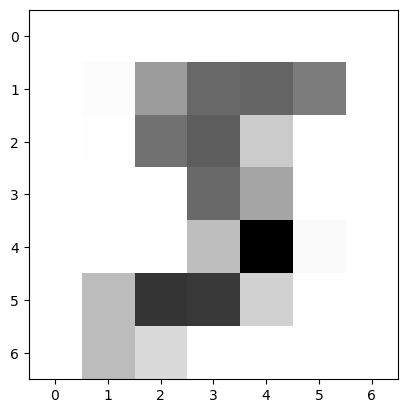

In [11]:
plt.imshow(np.column_stack([X_lowdim[:,i:j].sum(axis=1) for i,j in zip(e[:-1],e[1:])]) ,cmap='gray_r')

OK, great, now that we understand how the shapes work, we can apply this to the full matrix to get our training dataset!!

In [12]:
X_7x28 = np.hstack([X_all.reshape(-1,nPix,nPix)[:,i:j,:].sum(axis=1,keepdims=True) for i,j in zip(e[:-1],e[1:])])
X_7x7 = np.dstack([X_7x28[:,:,i:j].sum(axis=-1,keepdims=True) for i,j in zip(e[:-1],e[1:])]) 
X_7x7.shape

(60000, 7, 7)

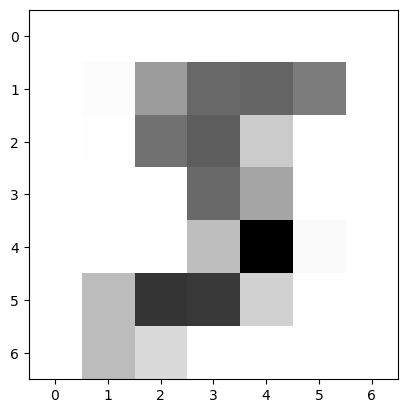

In [13]:
plt.imshow(X_7x7[idx],cmap='gray_r')

**Visualize the output:** 

Look at the avg image for each label.

At this resolution, can I still "by eye" tell the numbers apart?

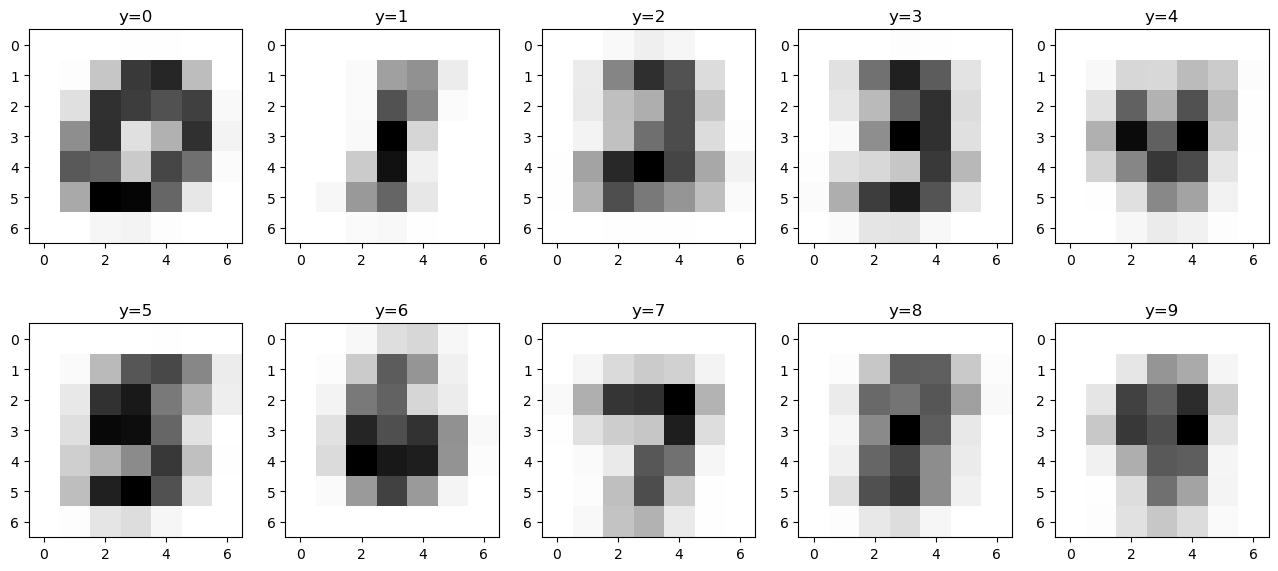

In [14]:
fig, axs = plt.subplots(2,5,figsize=(16,7) )

for yi,ax in enumerate(axs.flatten()):
    xi_avg = X_7x7[y_all==yi].sum(axis=0)
    ax.imshow(xi_avg,cmap='gray_r')
    ax.set_title(f'y={yi}')
plt.show()

OK, looks reasonable!! Let's see what we can do here!!

**Split into a training and val set**

Note: we have a different test set in the file that we can use for checking at the very end (after all hyperparameter optimization)

In [178]:
idx_all = np.arange(X_all.shape[0])
np.random.shuffle(idx_all)

nTrain = len(idx_all) * 8 // 10
idx_tr = idx_all[:nTrain]
idx_val =idx_all[nTrain:]

X_tr = torch.FloatTensor(X_7x7[idx_tr]).reshape(-1,49)
y_tr = torch.LongTensor(y_all[idx_tr])

X_val = torch.FloatTensor(X_7x7[idx_val]).reshape(-1,49)
y_val = torch.LongTensor(y_all[idx_val])


**Plan:** Build a linear model 

**Tip:** `nn.Linear`

In [180]:
bs = 512

X_tr[:bs]

tensor([[  0.,   0.,   0.,  ..., 298.,   0.,   0.],
        [  0.,   0.,   0.,  ..., 878.,   0.,   0.],
        [  0.,   0.,   0.,  ..., 471.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 294., 145.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.]])

In [181]:
W = nn.Linear(49,10)
out = W(X_tr[:bs])
out

tensor([[ -589.5193,   652.3392,  -663.1726,  ...,   -18.8498,  -644.6395,
          -409.3973],
        [ -577.8820,   461.0688,    43.8606,  ...,    55.1687, -1037.2461,
           410.5170],
        [ -249.7282,   836.0779,   -59.6116,  ...,   523.1332,  -502.9370,
           810.3782],
        ...,
        [  -30.6247,     5.8835,  -741.1841,  ...,   573.2814,  -983.2616,
           328.2632],
        [   53.4155,  -521.9693,   175.7231,  ...,   881.2329,  -141.1893,
          1564.3196],
        [ -413.6860,   224.6413,   -86.2121,  ...,   834.7637,  -716.7086,
          1092.3029]], grad_fn=<AddmmBackward0>)

In [20]:
out.shape

torch.Size([128, 10])

**Task 2:** Appply the softmax nonlinearity to interpret these as logits.

Look at the outputs, visualize in a histogram.

In [183]:
y_pred = nn.Softmax()(out)
y_pred.min(), y_pred.max()

(tensor(0., grad_fn=<MinBackward1>), tensor(1., grad_fn=<MaxBackward1>))

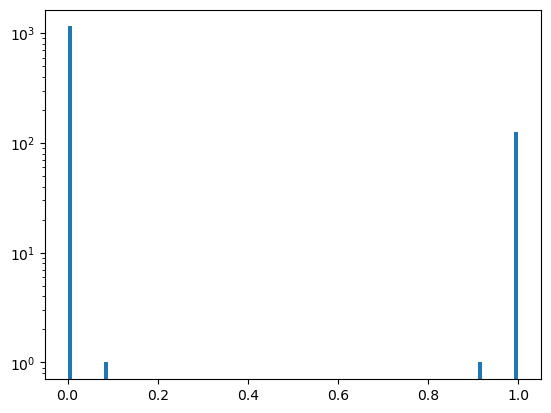

In [184]:
plt.hist(y_pred.detach().numpy().flatten(),100,log=True)
plt.show()

**Q:** What do you think? Do the results make sense?

<span style='color:blue'> **Soln:** The softmax output is _strongly_ sturated at either 0 or 1, but, this is bounded w/in the range we're expecting, so it is "technically correct".</span>

<span style='color:blue'> However, remember for the sigmoid when the output was either 0 or 1, the gradient was 0? These "saturating probabilities" is the first warning sign that the gradients won't be helpful... but the hw continues going thru some more steps so that you can learn how to diagnose similar problems in your research tasks.  </span>



**Task 3:** Calculate the softmax probability of this batch _before training_ 

<span style='color:blue'> **Soln:** The `nn.CrossEntropy` loss wants to accpe the inputs before the normalization. </span>

In [188]:
loss = nn.CrossEntropyLoss()(out,y_tr[:bs])
loss.item()

846.0015258789062

**Task 4:** Backprobagate through the loss and look at the gradients... what do you think?

In [189]:
loss.backward()

In [190]:
W.bias.grad

tensor([-0.0840,  0.0625, -0.1113,  0.0370, -0.0977, -0.0682,  0.0079,  0.0238,
        -0.1172,  0.3471])

In [191]:
W.weight.grad

tensor([[ 0.0000e+00,  0.0000e+00, -2.1484e-01, -3.3672e+00, -1.3574e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.1348e+00, -4.8059e+01,
         -1.5236e+02, -1.5748e+02, -4.4400e+01, -6.0547e-01,  0.0000e+00,
         -3.0643e+01, -1.8180e+02, -1.5579e+02, -1.5880e+02, -1.4620e+02,
         -7.4375e+00,  0.0000e+00, -9.4461e+01, -1.7336e+02, -1.9301e+01,
         -5.5803e+01, -1.8905e+02, -8.1172e+00,  1.0938e-01, -1.3246e+02,
         -1.4445e+02, -3.5143e+01, -1.3575e+02, -1.3848e+02, -2.6270e+00,
          1.8594e+00, -6.2887e+01, -1.8872e+02, -2.0214e+02, -1.3276e+02,
         -2.1057e+01,  0.0000e+00,  0.0000e+00, -2.6055e+00, -9.3066e+00,
         -7.4492e+00, -2.4883e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.1328e-01,  1.7031e+00,  3.3613e+00,  1.8320e+00,
          8.1445e-01,  0.0000e+00,  1.4453e-01,  2.1604e+01,  8.6931e+01,
          1.3905e+01,  1.1749e+01, -3.4336e+00, -7.9688e-01,  2.9222e+00,
          9.0968e+01,  3.1996e+02,  4.7958e+01,  2

The gradients are almost all zero, b/c we're saturating the Softmax function here...

Is it even possible to train smth?

In [193]:
# training loop

opt = torch.optim.Adam(W.parameters(),.001)

losses = []
for i in range(10000):
    idx_batch = np.random.choice(np.arange(X_tr.shape[0]),bs)
    Xi = X_tr[idx_batch]
    yi = y_tr[idx_batch]


    zi = W(Xi) # logits
    
    loss = nn.CrossEntropyLoss()(zi,yi)

    loss.backward()

    opt.step()
    W.zero_grad()
    
    losses.append(loss.item())

In [194]:
loss.item()

0.8284459710121155

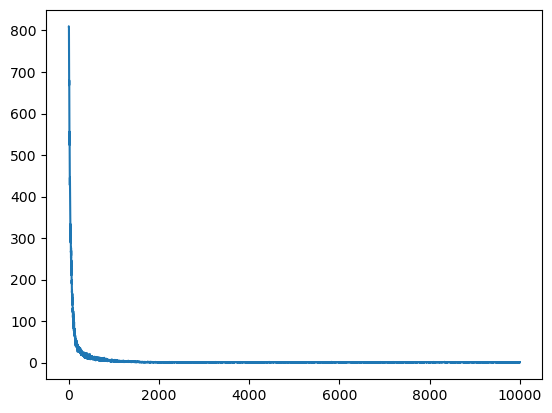

In [195]:
plt.plot(losses)

**Check the accuracy**

In [196]:
# Now, eval on the train set
pred = torch.argmax(W(X_tr),axis=1)
torch.sum(pred==y_tr)/len(y_tr)

tensor(0.8562)

In [197]:
pred = torch.argmax(W(X_val),axis=1)
torch.sum(pred==y_val)/len(y_val)

tensor(0.8533)

## Can we improve on this result??

💡 Try to preprocess the inputs first

- [ ] Visualize the current `X_tr` freatures
- [ ] normalize to zero mean and unit variance
- [ ] Visualize the new normalized `X_tr` again

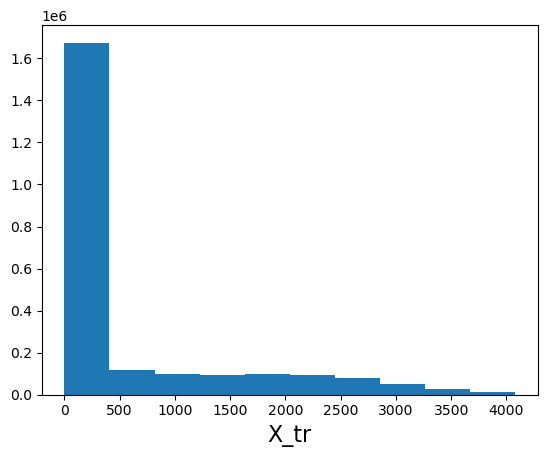

In [225]:
plt.hist(X_tr.numpy().flatten())
plt.xlabel('X_tr',fontsize=16)
plt.show()

In [202]:
mu = torch.mean(X_tr)
std = torch.std(X_tr)

In [203]:
X_tr_norm = (X_tr-mu)/std
X_val_norm = (X_val-mu)/std

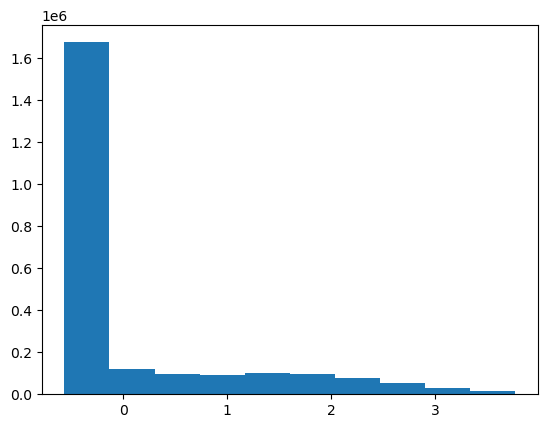

In [204]:
plt.hist(X_tr_norm.flatten().numpy())
plt.xlabel('X_tr_norm',fontsize=16)
plt.show()

## Retrain with the preprocessed inputs

Re-init a new model and rinse and repeat.

In [206]:
W_new = nn.Linear(49,10)

In [207]:
W_new(X_tr_norm)

tensor([[ 0.3195,  1.0780, -0.5423,  ..., -0.2189,  0.3065, -0.3652],
        [ 0.4023,  1.0076,  0.2384,  ..., -0.9290,  0.5780,  0.6253],
        [ 1.2852,  0.8016, -0.2217,  ..., -0.4967, -0.1323,  0.6563],
        ...,
        [ 0.0522,  0.7867, -0.1752,  ..., -0.0164,  0.7478,  0.2517],
        [ 0.7513,  0.8609,  0.3002,  ..., -0.5633,  1.2559, -0.0434],
        [ 1.2930, -0.1601,  0.3708,  ..., -0.5462,  0.2708,  0.3794]],
       grad_fn=<AddmmBackward0>)

**What do you expect the loss to be _before_ training?**

<span style='color:blue'> **Soln:**
$$-\log (1/10) = \log 10 = 2.3$$</span>

In [226]:
np.log(10)

np.float64(2.302585092994046)

**Test it out:** Look at your initial loss 

In [208]:
nn.CrossEntropyLoss()(W_new(X_tr_norm),y_tr)

tensor(2.5316, grad_fn=<NllLossBackward0>)

**Does it agree with your expectation?**

<span style='color:blue'> **Soln:**  Yes, with the normalized input features, now the loss is pretty close to what we were expecting ! 🥳 </span>

**Set up the training loop:**

In [209]:
# training loop
opt2 = torch.optim.Adam(W_new.parameters(),.001)

losses = []
for i in range(2000):
    idx_batch = np.random.choice(np.arange(X_tr.shape[0]),bs)
    Xi = X_tr_norm[idx_batch]
    yi = y_tr[idx_batch]


    zi = W_new(Xi) # logits
    
    loss = nn.CrossEntropyLoss()(zi,yi)

    loss.backward()

    opt2.step()
    W_new.zero_grad()
    
    losses.append(loss.item())

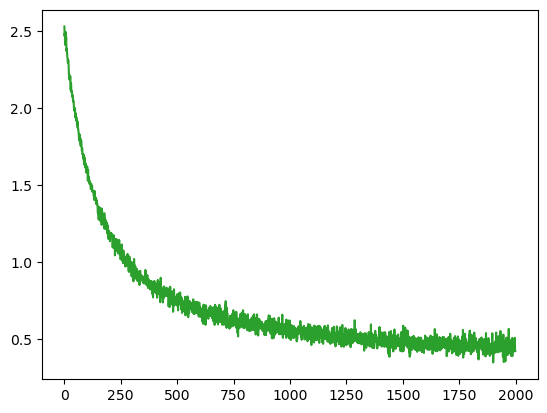

In [210]:
plt.plot(losses,color='C2')
# plt.xscale('log')

<span style='color:blue'> **Soln:**  Note the loss starts _way_ lower now! Note, the first training loop without the normalized features is pretty sensitive to the random initialization whether or not it converges to smth meaningful. </span>

In [211]:
'''
TO DO: eval on the train set
'''

# Now, eval on the train set
pred = torch.argmax(W_new(X_tr_norm),axis=1)
torch.sum(pred==y_tr)/len(y_tr)

tensor(0.8726)

In [212]:
'''
TO DO: eval on the val set
'''
pred = torch.argmax(W_new((X_val-mu)/std),axis=1)
torch.sum(pred==y_val)/len(y_val)

tensor(0.8712)

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_83067/689790803.py:1: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(pred,10,(-.5,9.5),density=True)


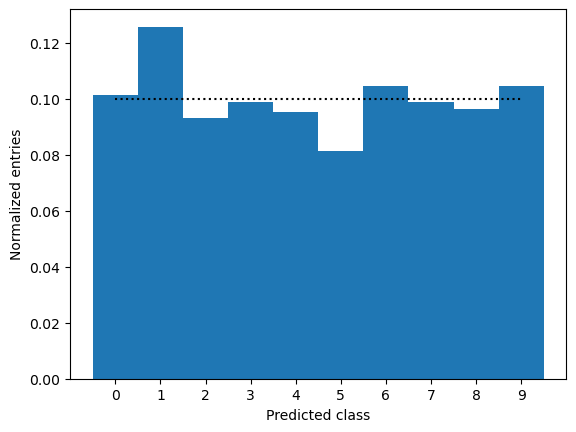

In [213]:
'''
TO DO: Predict the density of the model output scores
'''

plt.hist(pred,10,(-.5,9.5),density=True)
plt.xticks(np.arange(10))
plt.hlines(.1,0,9,color='k',ls=':')
plt.xlabel('Predicted class')
plt.ylabel('Normalized entries')
plt.show()

**Model interpretation:** Next,  make a "confusion matrix" to vizualize which classes are getting confused?

**Tip:** Look into `sklearn.metrics.ConfusionMatrixDisplay`


In [217]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [216]:
# !pip install scikit-learn 

In [218]:
# ?ConfusionMatrixDisplay.from_predictions

<Figure size 1500x1500 with 0 Axes>

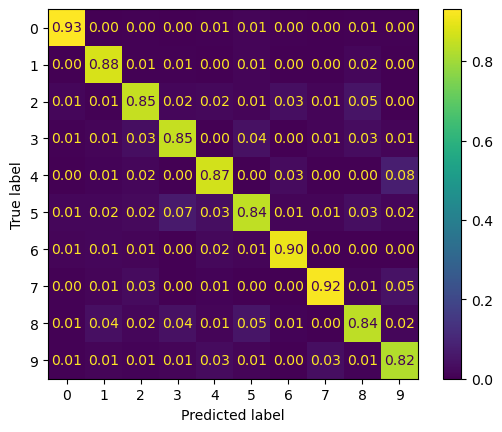

In [219]:
plt.figure(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_val,pred,normalize='pred',
                                        values_format='.2f',#cmap='turbo',
                                        # im_kw={'norm':LogNorm()}
                                       )

In [220]:
np.unique(pred,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1216, 1508, 1118, 1187, 1144,  977, 1255, 1186, 1156, 1253]))

**What arey you learning from this?**

**Your answer:**

When looking at the proportion of predicted events, I saw I was having a deficit for predicting 5s and 8s
- 5s are most often getting predicted as 3s adn 8s
- 8s get predicted as 2s 3s or 5s

This makes sense,each of these numbers look visually similar to each other.

**Last step: NN architect:** Can you code up the `Softmax` yourself and cross check the performance with the `nn.Softmax` function?

In [221]:
logit = W_new(X_tr_norm[:10])
out_torch = nn.Softmax()(logit)
out_torch

/Users/nicolehartman/miniforge3/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[2.5275e-03, 1.3694e-03, 2.0362e-03, 8.5564e-03, 7.6157e-01, 2.0658e-02,
         2.9157e-02, 9.7552e-04, 5.2993e-03, 1.6785e-01],
        [2.5488e-04, 5.4406e-04, 6.0012e-04, 3.0112e-02, 4.7775e-04, 1.1922e-02,
         1.0236e-04, 7.7040e-01, 3.7544e-02, 1.4804e-01],
        [2.2044e-04, 1.0469e-04, 2.1936e-03, 7.9228e-02, 1.0839e-04, 7.5641e-01,
         1.3577e-04, 1.8120e-03, 1.4164e-01, 1.8137e-02],
        [3.5581e-03, 1.4414e-03, 1.2439e-01, 1.7591e-03, 6.5635e-01, 6.1589e-04,
         2.1779e-02, 2.7153e-02, 1.8242e-03, 1.6113e-01],
        [2.8427e-03, 9.7454e-05, 6.9982e-03, 7.2421e-05, 8.5031e-01, 1.0439e-03,
         9.0835e-03, 3.0656e-03, 4.3617e-03, 1.2213e-01],
        [1.6401e-04, 1.0553e-04, 2.7011e-03, 9.9547e-01, 8.7684e-07, 9.1432e-04,
         7.4615e-06, 2.4598e-05, 6.0333e-04, 6.6675e-06],
        [6.0957e-03, 1.2487e-04, 2.7019e-01, 1.1468e-02, 3.4729e-03, 1.7544e-03,
         6.9995e-01, 1.8675e-03, 4.8788e-03, 2.0196e-04],
        [2.0902e-03, 4.5536

In [222]:
exp_z = torch.exp(logit)

out_me = exp_z / torch.sum(exp_z,axis=1,keepdims=True)
out_me

tensor([[2.5275e-03, 1.3694e-03, 2.0362e-03, 8.5564e-03, 7.6157e-01, 2.0658e-02,
         2.9157e-02, 9.7552e-04, 5.2993e-03, 1.6785e-01],
        [2.5488e-04, 5.4406e-04, 6.0012e-04, 3.0112e-02, 4.7775e-04, 1.1922e-02,
         1.0236e-04, 7.7040e-01, 3.7544e-02, 1.4804e-01],
        [2.2044e-04, 1.0469e-04, 2.1936e-03, 7.9228e-02, 1.0839e-04, 7.5641e-01,
         1.3577e-04, 1.8120e-03, 1.4164e-01, 1.8137e-02],
        [3.5581e-03, 1.4414e-03, 1.2439e-01, 1.7591e-03, 6.5635e-01, 6.1589e-04,
         2.1779e-02, 2.7153e-02, 1.8242e-03, 1.6113e-01],
        [2.8427e-03, 9.7454e-05, 6.9982e-03, 7.2421e-05, 8.5031e-01, 1.0439e-03,
         9.0835e-03, 3.0656e-03, 4.3617e-03, 1.2213e-01],
        [1.6401e-04, 1.0553e-04, 2.7011e-03, 9.9547e-01, 8.7684e-07, 9.1432e-04,
         7.4615e-06, 2.4598e-05, 6.0333e-04, 6.6675e-06],
        [6.0957e-03, 1.2487e-04, 2.7019e-01, 1.1468e-02, 3.4729e-03, 1.7544e-03,
         6.9995e-01, 1.8675e-03, 4.8788e-03, 2.0196e-04],
        [2.0902e-03, 4.5536

In [223]:
torch.isclose(out_torch,out_me)

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

**Does it match?** why or why not?

**Your answer:**

**Follow-up analysis:** In your own words, describe what you learned and key take-aways from this lesson.

**Your answer:**